In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.datatypes.utils.DataType import DataType
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import time

In [2]:
mergedData = pd.read_excel('TabellaFinaleSenzaNaN.xlsx', sheet_name=None)

In [3]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  \
0           0      2236      0   64 2021-02-26 00:00:00        27.30   
1           1      6426      0   48 2021-04-02 00:00:00         2.56   
2           2      8377      0   56 2020-08-31 00:00:00         7.80   
3           3     11463      0   71 2020-08-31 00:00:00        24.74   
4           4     11463      0   71 2021-03-31 10:54:33        -1.00   

   DATA_INT  num_visita  Charlson_Totale  Charlson_Diabete  ...  Stress level  \
0       422           0               -1                -1  ...             0   
1       457           0                2                 0  ...             0   
2       243           0                1                 0  ...            -1   
3       243           0                3                 0  ...            -1   
4       456           1               -1                -1  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2              -1             -1                 -1                -1   
3              -1             -1                 -1                -1   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                       -1         -1                   -1          -1   
3                       -1         -1                   -1          -1   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 81 columns]

In [4]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [5]:
df.head()

HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0      2236      0   64 2021-02-26 00:00:00        27.30       422   
1      6426      0   48 2021-04-02 00:00:00         2.56       457   
2      8377      0   56 2020-08-31 00:00:00         7.80       243   
3     11463      0   71 2020-08-31 00:00:00        24.74       243   
4     11463      0   71 2021-03-31 10:54:33        -1.00       456   

   num_visita  Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0           0               -1                -1       6.7  ...             0   
1           0                2                 0      -1.0  ...             0   
2           0                1                 0      -1.0  ...            -1   
3           0                3                 0      -1.0  ...            -1   
4           1               -1                -1      -1.0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2              -1             -1                 -1                -1   
3              -1             -1                 -1                -1   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                       -1         -1                   -1          -1   
3                       -1         -1                   -1          -1   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 80 columns]

In [6]:
df.to_csv('TabellaFinaleInput.csv', index=False)
df.to_excel('TabellaFinaleInput.xlsx', index=False)

## Parametri utente

In [7]:
input_data = 'TabellaFinaleInput.csv' 
mode = 'correlated_attribute_mode'
#description_file = 'description_500_completa_correlated_datatypes_0_degree_no_nan.json'
description_file = 'description_definitiva_-1.json'
synthetic_data = 'synthetic_data_-1_def.csv'

In [8]:
#for col in df.columns:
#    print(f'\'{col}\': False,')

In [9]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 20

attr_to_datatype = {'HDN_CODE': DataType.INTEGER,
                    'Sesso': DataType.INTEGER,
                    'ETA': DataType.INTEGER,
                    'DATA': DataType.DATETIME,
                    'ASCVD_Score': DataType.FLOAT,
                    'DATA_INT': DataType.INTEGER,
                    'num_visita': DataType.INTEGER,
                    'Charlson_Diabete': DataType.INTEGER,
                    'Stifness': DataType.FLOAT,
                    'CAP': DataType.INTEGER ,
                    'FrailtyPhenotypeBool': DataType.INTEGER ,
                    'EGA_HB': DataType.FLOAT,
                    'EGA_PaO2': DataType.FLOAT ,
                    'EGA_SatO2': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_FEV_FVCPre': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MEP': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MIP': DataType.FLOAT ,
                    'Pneumo_ScalaBorg': DataType.FLOAT ,
                    'TestCammino6Min_BorgBase': DataType.FLOAT ,
                    'TestCammino6Min_BorgEnd': DataType.FLOAT ,
                    'TestCammino6Min_Distanza': DataType.INTEGER ,
                    'Alcool': DataType.INTEGER ,
                    'BMI': DataType.FLOAT ,
                    'BMI_Ricovero': DataType.FLOAT ,
                    'BMIPostRicovero': DataType.FLOAT ,
                    'Fumatore': DataType.INTEGER ,
                    'Pack_years': DataType.INTEGER ,
                    'Sintomi_Cadute': DataType.INTEGER ,
                    'Sintomi_DifficoltaDeglutizione': DataType.INTEGER ,
                    'Sintomi_DistUdito': DataType.INTEGER ,
                    'Sintomi_DistVista': DataType.INTEGER ,
                    'SintomiNeuropsico_Ageusia': DataType.INTEGER ,
                    'SintomiNeuropsico_Anosmia': DataType.INTEGER ,
                    'SintomiNeuropsico_Astenia': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoAttenzione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoConcentrazione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoMemoria': DataType.INTEGER ,
                    'SintomiNeuropsico_DistEquilibrio': DataType.INTEGER ,
                    'SintomiNeuropsico_DistSonno': DataType.INTEGER ,
                    'SintomiNeuropsico_DoloriMuscolari': DataType.INTEGER ,
                    'SintomiNeuropsico_Effluvium': DataType.INTEGER ,
                    'VitaCm': DataType.INTEGER ,
                    'CALORIE': DataType.INTEGER ,
                    'PROTEINE_Perc': DataType.FLOAT ,
                    'CogStateScore_Esito': DataType.INTEGER ,
                    'GlobuliBianchi': DataType.INTEGER ,
                    'Linfociti_Assoluti': DataType.INTEGER ,
                    'Neutrofili':DataType.FLOAT  ,
                    'Piastrine': DataType.INTEGER ,
                    'GPT_ALT': DataType.INTEGER ,
                    'D_dimero': DataType.INTEGER ,
                    'Fibrinogeno': DataType.INTEGER ,
                    'Glicemia': DataType.INTEGER ,
                    'INSULINA': DataType.FLOAT ,
                    'PCR': DataType.FLOAT ,
                    
                    'DurataRicovero': DataType.INTEGER ,
                    'TempoDallaVisita': DataType.INTEGER ,
                    
                    'Descrizione': DataType.INTEGER ,
                    'AssumePiuFarmaciGiorno': DataType.INTEGER ,
                    'PersoPeso': DataType.INTEGER ,
                    'CamminareMenoUltimoAnno': DataType.INTEGER ,
                    'CaduteUltimoAnno':  DataType.INTEGER,
                    'SentirsiSolo': DataType.INTEGER ,
                    'PuoContareSuQualcuno': DataType.INTEGER ,
                    'DifficoltaEconomicheSpeseSanitarie': DataType.INTEGER ,
                    'EQ5D5L': DataType.FLOAT ,
                    'EQ5D5L health score': DataType.INTEGER ,
                    'Intrinsic Capacity (%)': DataType.FLOAT ,
                    'DASS21 stress': DataType.INTEGER ,
                    'Stress level': DataType.INTEGER ,
                    'DASS21 anxiety': DataType.INTEGER ,
                    'Anxiety level': DataType.INTEGER ,
                    'DASS21 depression': DataType.INTEGER ,
                    'Depression level': DataType.INTEGER ,
                    'Insomnia severity index': DataType.INTEGER ,
                    'ISI level': DataType.INTEGER ,
                    'SF36 general health': DataType.INTEGER ,
                    'Resilience': DataType.INTEGER,
                    'Outcome': DataType.INTEGER}

# specify categorical attributes
categorical_attributes = {#'HDN_CODE': False,
                          'Sesso': True,
                          #'ETA': False,
                          #'DATA': False,
                          #'ASCVD_Score': False,
                          #'DATA_INT': False,
                          'num_visita': True,
                          'Charlson_Totale': True,
                          'Charlson_Diabete': True,
                          #'Stifness': False,
                          #'CAP': False,
                          'FrailtyPhenotypeBool': True,
                          #'EGA_HB': False,
                          #'EGA_PaO2': False,
                          #'EGA_SatO2': False,
                          #'Pneumo_ProveFunzResp_FEV_FVCPre': False,
                          #'Pneumo_ProveFunzResp_MEP': False,
                          #'Pneumo_ProveFunzResp_MIP': False,
                          'Pneumo_ScalaBorg': True,
                          'TestCammino6Min_BorgBase': True,
                          'TestCammino6Min_BorgEnd': True,
                          #'TestCammino6Min_Distanza': False,
                          'Alcool': True,
                          #'BMI': False,
                          #'BMI_Ricovero': False,
                          #'BMIPostRicovero': False,
                          'Fumatore': True,
                          #'Pack_years': False,
                          'Sintomi_Cadute': True,
                          'Sintomi_DifficoltaDeglutizione': True,
                          'Sintomi_DistUdito': True,
                          'Sintomi_DistVista': True,
                          'SintomiNeuropsico_Ageusia': True,
                          'SintomiNeuropsico_Anosmia': True,
                          'SintomiNeuropsico_Astenia': True,
                          'SintomiNeuropsico_CognitivoAttenzione': True,
                          'SintomiNeuropsico_CognitivoConcentrazione': True,
                          'SintomiNeuropsico_CognitivoMemoria': True,
                          'SintomiNeuropsico_DistEquilibrio': True,
                          'SintomiNeuropsico_DistSonno': True,
                          'SintomiNeuropsico_DoloriMuscolari': True,
                          'SintomiNeuropsico_Effluvium': True,
                          #'VitaCm': False,
                          #'CALORIE': False,
                          #'PROTEINE_Perc': False,
                          'CogStateScore_Esito': True,
                          #'GlobuliBianchi': False,
                          #'Linfociti_Assoluti': False,
                          #'Neutrofili': False,
                          #'Piastrine': False,
                          #'GPT_ALT': False,
                          #'D_dimero': False,
                          #'Fibrinogeno': False,
                          #'Glicemia': False,
                          #'INSULINA': False,
                          #'PCR': False,
                          
                          #'DurataRicovero': False,
                          #'TempoDallaVisita': False,
                          
                          'Descrizione': True,
                          'AssumePiuFarmaciGiorno': True,
                          'PersoPeso': True,
                          'CamminareMenoUltimoAnno': True,
                          'CaduteUltimoAnno': True,
                          'SentirsiSolo': True,
                          'PuoContareSuQualcuno': True,
                          'DifficoltaEconomicheSpeseSanitarie': True,
                          #'EQ5D5L': False,
                          #'EQ5D5L health score': False,
                          #'Intrinsic Capacity (%)': False,
                          #'DASS21 stress': True,
                          'Stress level': True,
                          #'DASS21 anxiety': True,
                          'Anxiety level': True,
                          #'DASS21 depression': True,
                          'Depression level': True,
                          #'Insomnia severity index': True,
                          'ISI level': True,
                          #'SF36 general health': False,
                          #'Resilience': False
                          'Outcome':True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 0

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 5000

In [ ]:
# istanzio il data describer
describer = DataDescriber()
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_datatype=attr_to_datatype,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

In [ ]:
display_bayesian_network(describer.bayesian_network)

In [ ]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [10]:
dfs = pd.read_csv(synthetic_data)

## Ispector

In [11]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']
inspector = ModelInspector(input_df, synthetic_df, attribute_description)

In [ ]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

In [ ]:
#inspector.mutual_information_heatmap()

In [ ]:
'''plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()'''

'plt.figure(figsize=(8, 6))\nsns.heatmap(df.corr(), annot=True)\nplt.show()'

In [12]:
dfs.head()

HDN_CODE  Sesso   ETA          DATA  ASCVD_Score  DATA_INT  num_visita  \
0         0      1  55.0  1.599269e+09     7.324930     426.0           1   
1         1      1  51.0  1.601155e+09     0.865133     378.0           0   
2         2      0  57.0  1.615683e+09     3.879490     281.0           0   
3         3      1  41.0  1.610522e+09    -0.749886     455.0           1   
4         4      1  50.0  1.596199e+09     0.667004     279.0           0   

   Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0                1                 0  4.728964  ...             1   
1               -1                -1 -0.024939  ...             4   
2                1                 0  0.759540  ...            -1   
3               -1                -1  0.212394  ...             0   
4                1                 0  6.428941  ...            -1   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               4              1                  6                 1   
1              11              0                  6                 1   
2              -1             -1                 -1                -1   
3               1              0                  3                 0   
4              -1             -1                 -1                -1   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                      4.0          0                 46.0        52.0   
1                     26.0          1                 28.0        42.0   
2                     -1.0         -1                  4.0         2.0   
3                      7.0          1                 65.0        72.0   
4                     -1.0         -1                  1.0         0.0   

   Outcome  
0        0  
1        1  
2       -1  
3        1  
4       -1  

[5 rows x 80 columns]

In [13]:
df.head()

HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0      2236      0   64 2021-02-26 00:00:00        27.30       422   
1      6426      0   48 2021-04-02 00:00:00         2.56       457   
2      8377      0   56 2020-08-31 00:00:00         7.80       243   
3     11463      0   71 2020-08-31 00:00:00        24.74       243   
4     11463      0   71 2021-03-31 10:54:33        -1.00       456   

   num_visita  Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0           0               -1                -1       6.7  ...             0   
1           0                2                 0      -1.0  ...             0   
2           0                1                 0      -1.0  ...            -1   
3           0                3                 0      -1.0  ...            -1   
4           1               -1                -1      -1.0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2              -1             -1                 -1                -1   
3              -1             -1                 -1                -1   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                       -1         -1                   -1          -1   
3                       -1         -1                   -1          -1   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 80 columns]

In [14]:
frames = [df, dfs]

result = pd.concat(frames)

<AxesSubplot:>

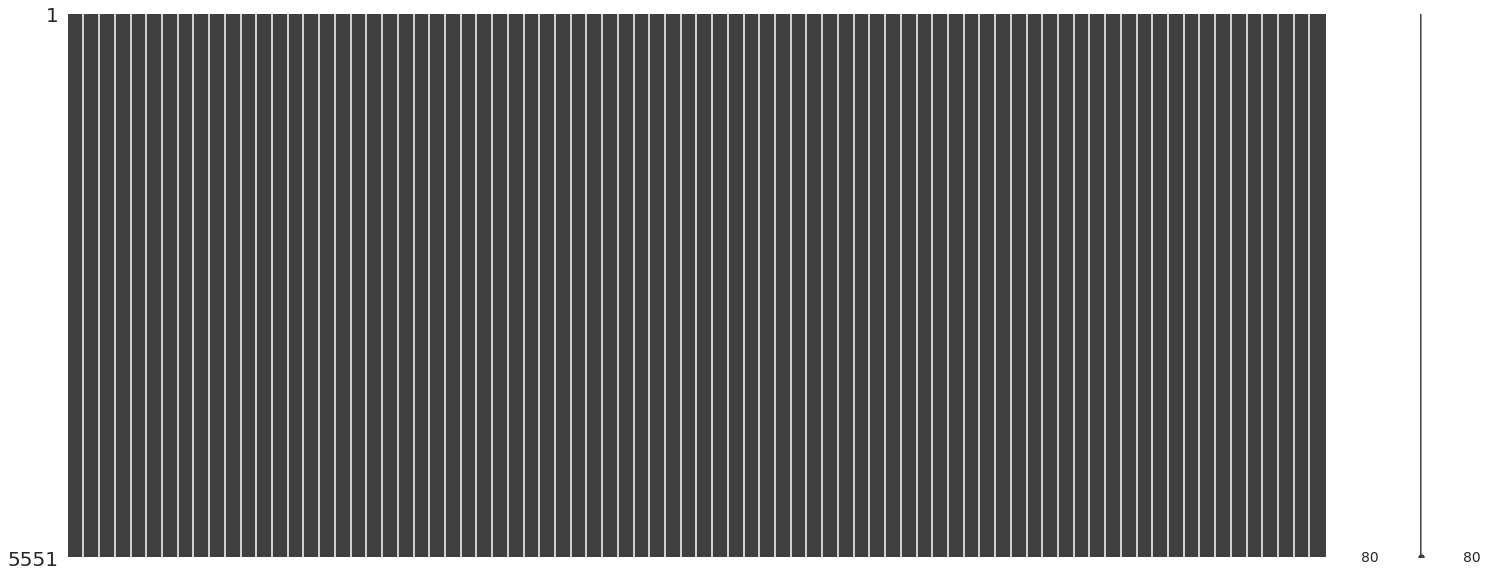

In [15]:
msno.matrix(result)

In [16]:
# rimetto i valori nan che erano stati imputati a nan
result.loc[result['Outcome'] == -1, 'Outcome'] = np.nan

<AxesSubplot:>

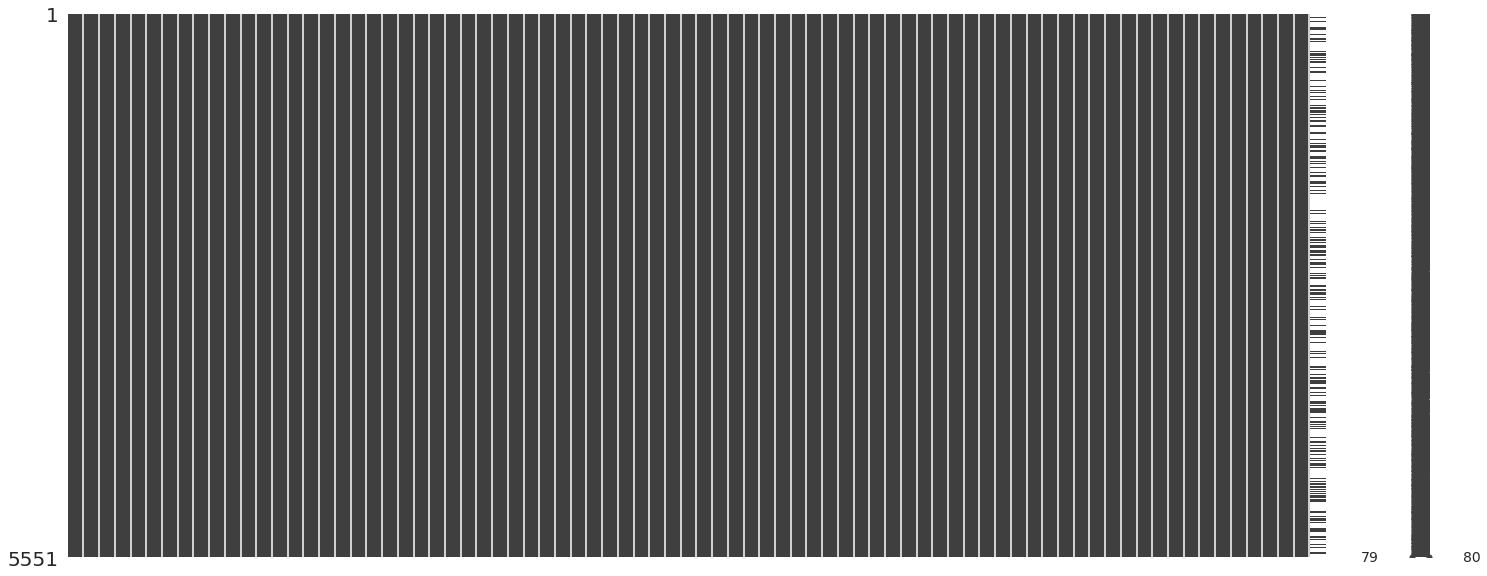

In [17]:
msno.matrix(result)

In [18]:
for col in result:
    #get dtype for column
    dt = result[col].dtype 
    #check if it is a number
    if col != 'Outcome':
        if dt == int or dt == float:
            result.loc[result[col]<0, col] = np.nan
        else:
            result.loc[result[col] == "", col] = np.nan

<AxesSubplot:>

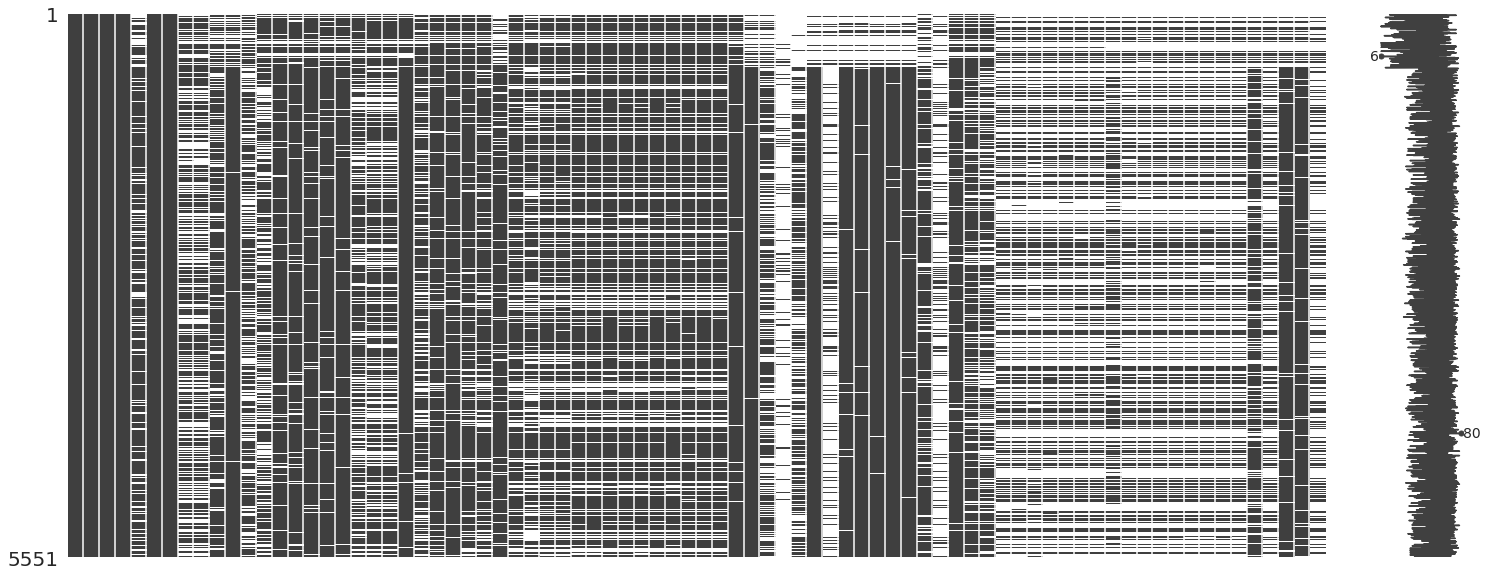

In [19]:
msno.matrix(result)

In [20]:
percent_missing = result.isnull().sum() * 100 / len(result)
missing_value_df = pd.DataFrame({'column_name': result.columns,
                                 'percent_missing': percent_missing})

In [21]:
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

column_name  percent_missing
HDN_CODE                              HDN_CODE         0.000000
Sesso                                    Sesso         0.000000
ETA                                        ETA         0.000000
DATA                                      DATA         0.000000
DATA_INT                              DATA_INT         0.000000
...                                        ...              ...
Intrinsic Capacity (%)  Intrinsic Capacity (%)        63.267880
Outcome                                Outcome        67.987750
PCR                                        PCR        78.580436
Neutrofili                          Neutrofili        79.823455
CogStateScore_Esito        CogStateScore_Esito        89.731580

[80 rows x 2 columns]

In [22]:
#X = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]
X = result.copy(deep=True)#[(result['Outcome'].notna())]
X.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

# = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]['Outcome']
y = result['Outcome']#[(result['Outcome'].notna())]['Outcome']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)#, test_size=0.25)#, shuffle=False)

In [23]:
percent_missing = X.isnull().sum() * 100 / len(X)
missing_value_df = pd.DataFrame({'column_name': X.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df['percent_missing'])

HDN_CODE                                      0.000000
Sesso                                         0.000000
ETA                                           0.000000
DATA_INT                                      0.000000
num_visita                                    0.000000
TestCammino6Min_Distanza                      4.323545
VitaCm                                        4.575752
CAP                                           5.008107
CALORIE                                       6.143037
Pneumo_ProveFunzResp_MIP                      7.512160
Pneumo_ProveFunzResp_MEP                      7.692308
Linfociti_Assoluti                            7.926500
Pneumo_ProveFunzResp_FEV_FVCPre               8.106647
D_dimero                                      8.232751
BMI                                           8.394884
DurataRicovero                                8.484958
Fibrinogeno                                   8.611061
Piastrine                                     9.241578
GPT_ALT   

In [24]:
# alzare la soglia per includere charlson
perc = 40.0
min_count =  int(((100-perc)/100)*X.shape[0] + 1)
mod_df = X.dropna(axis=1, 
                thresh=min_count)

<AxesSubplot:>

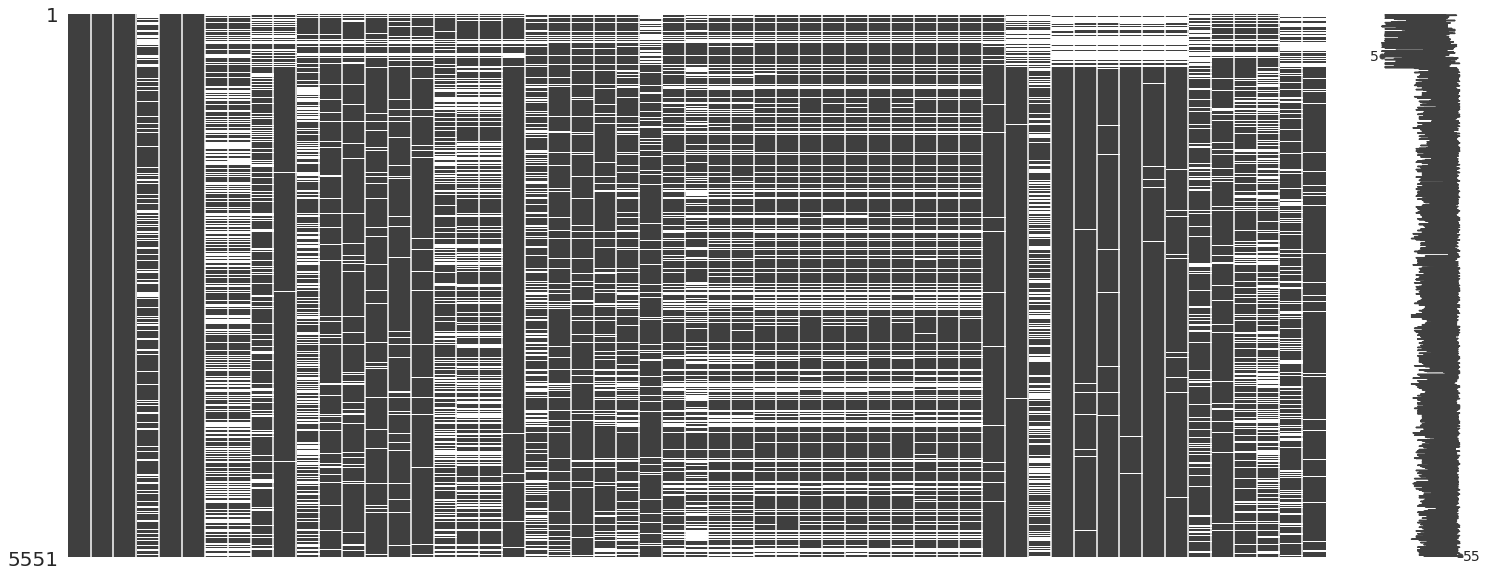

In [25]:
msno.matrix(mod_df)

In [26]:
mod_df.shape

(5551, 55)

In [27]:
set(X.columns) - set(mod_df.columns)

{'Anxiety level',
 'AssumePiuFarmaciGiorno',
 'CaduteUltimoAnno',
 'CamminareMenoUltimoAnno',
 'CogStateScore_Esito',
 'DASS21 anxiety',
 'DASS21 depression',
 'DASS21 stress',
 'Depression level',
 'DifficoltaEconomicheSpeseSanitarie',
 'EQ5D5L',
 'EQ5D5L health score',
 'GlobuliBianchi',
 'ISI level',
 'Intrinsic Capacity (%)',
 'Neutrofili',
 'PCR',
 'PersoPeso',
 'PuoContareSuQualcuno',
 'SentirsiSolo',
 'Stress level'}

In [28]:
y.isna().value_counts()

True     3774
False    1777
Name: Outcome, dtype: int64

# Test dataset completo

---



In [29]:
# tentativi con i dataset concatenati e senza rimozione dei valori null
model = XGBClassifier(max_depth=5, n_estimators=140, objective='multi:softprob')

model.fit(x_train, y_train)

y_test_hat = model.predict(x_test)

temp_df = pd.DataFrame(y_test)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_filled = temp_df['Outcome'].to_numpy()

temp_df = pd.DataFrame(y_test_hat)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_hat_filled = temp_df[0].to_numpy()

# con i nan non funziona 
print("Accuracy modello: ", accuracy_score(y_test_filled, y_test_hat_filled))

/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy modello:  0.904178674351585


In [30]:
# la cross val non si può fare per colpa dei nan
temp_df = pd.DataFrame(y_train)
temp_df.fillna(-1, axis=1, inplace=True)
y_train_filled = temp_df['Outcome'].to_numpy()
print("cross val modello: ", cross_val_score(model, x_train, y_train_filled))

[11:48:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cross val modello:  [0.9027611  0.89555822 0.91116447 0.90384615 0.90384615]


<AxesSubplot:>

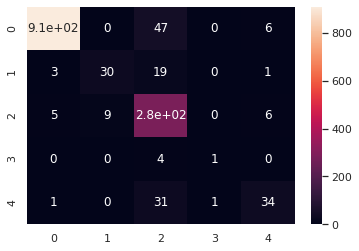

In [31]:
#plot_confusion_matrix(model, x_test, y_test)
#confusion_matrix(y_test, y_test_hat)
df_cm = pd.DataFrame(confusion_matrix(y_test_filled, y_test_hat_filled))
plt.figure()
sns.heatmap(df_cm, annot=True)

In [32]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [33]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [34]:
# troppo grande per riuscire ad eseguire
import time
start_time = time.time()
y_train_filled = y_train.fillna(-1)
grid_search.fit(x_train, y_train_filled)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
--- 8433.528101921082 seconds ---


In [35]:
grid_search.best_estimator_

XGBClassifier(max_depth=5, n_estimators=140, objective='multi:softprob')

In [ ]:
# risultato esecuzione grid search
'''XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              
  XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=180,
              objective='multi:softprob', tree_method='gpu_hist')'''

## Testing con solo dataset iniziale

---



In [34]:
# dataset solo iniziale

#X = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]
X_df = df.copy(deep=True)#[(df['Outcome'].notna())]
X_df.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

# = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]['Outcome']
y_df = df['Outcome']#[(df['Outcome'].notna())]['Outcome']

x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, random_state=42)#, test_size=0.25)#, shuffle=False)

In [35]:
model_df = XGBClassifier(learning_rate=0.01, max_depth=4, objective='multi:softprob')
model_df.fit(x_train_df, y_train_df)

y_test_hat_df = model_df.predict(x_test_df)

temp_df = pd.DataFrame(y_test_df)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_df_filled = temp_df['Outcome'].to_numpy()

temp_df = pd.DataFrame(y_test_hat_df)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_hat_df_filled = temp_df[0].to_numpy()

# con i nan non funziona 
print("Accuracy modello 1: ", accuracy_score(y_test_df_filled, y_test_hat_df_filled))

/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy modello 1:  0.8695652173913043


In [36]:
temp_df = pd.DataFrame(y_train_df)
temp_df.fillna(-1, axis=1, inplace=True)
y_train_df_filled = temp_df['Outcome'].to_numpy()
print("cross val modello 1: ", cross_val_score(model_df, x_train_df, y_train_df_filled))

[11:49:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[11:49:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cross val modello 1:  [0.87951807 0.89156627 0.90361446 0.8902439  0.92682927]


In [37]:
grid_search_df = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [38]:
# troppo grande per riuscire ad eseguire
import time
start_time = time.time()
y_train_df_filled = y_train_df.fillna(-1)
grid_search_df.fit(x_train_df, y_train_df_filled)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


--- 524.9661252498627 seconds ---


In [39]:
grid_search_df.best_estimator_

XGBClassifier(learning_rate=0.01, max_depth=4, objective='multi:softprob')

<AxesSubplot:>

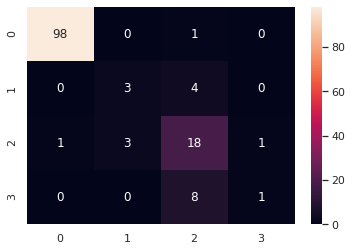

In [38]:
df_cm = pd.DataFrame(confusion_matrix(y_test_df_filled, y_test_hat_df_filled))
plt.figure()
sns.heatmap(df_cm, annot=True)

In [39]:
np.unique(y_test_df_filled, return_counts=True)

(array([-1,  0,  1,  3]), array([99,  7, 23,  9]))

# Test con solo dataset sintetico

---

In [40]:
dfs.loc[dfs['Outcome'] == -1, 'Outcome'] = np.nan

In [41]:
for col in dfs:
    #get dtype for column
    dt = dfs[col].dtype 
    #check if it is a number
    if col != 'Outcome':
        if dt == int or dt == float:
            dfs.loc[dfs[col]<0, col] = np.nan
        else:
            dfs.loc[dfs[col] == "", col] = np.nan

In [42]:
# solo dataset sintetico

#X = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]
X_dfs = dfs.copy(deep=True)#[(dfs['Outcome'].notna())]
X_dfs.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

# = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]['Outcome']
y_dfs = dfs['Outcome']#[(dfs['Outcome'].notna())]['Outcome']

x_train_dfs, x_test_dfs, y_train_dfs, y_test_dfs = train_test_split(X_dfs, y_dfs, random_state=42)#, test_size=0.25)#, shuffle=False)

In [43]:
model_dfs = XGBClassifier(learning_rate=0.05, max_depth=9, n_estimators=180,
              objective='multi:softprob')
model_dfs.fit(x_train_dfs, y_train_dfs)

y_test_hat_dfs = model_dfs.predict(x_test_dfs)

temp_df = pd.DataFrame(y_test_dfs)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_dfs_filled = temp_df['Outcome'].to_numpy()

temp_df = pd.DataFrame(y_test_hat_dfs)
temp_df.fillna(-1, axis=1, inplace=True)
y_test_hat_dfs_filled = temp_df[0].to_numpy()

# con i nan non funziona 
print("Accuracy modello 1: ", accuracy_score(y_test_dfs_filled, y_test_hat_dfs_filled))
#print("Accuracy modello 2: ", accuracy_score(y_test_df, y_test_hat_2_df))

/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy modello 1:  0.9072


In [44]:
temp_df = pd.DataFrame(y_train_dfs)
temp_df.fillna(-1, axis=1, inplace=True)
y_train_dfs_filled = temp_df['Outcome'].to_numpy()
print("cross val modello : ", cross_val_score(model_dfs, x_train_dfs, y_train_dfs_filled))

[11:49:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cross val modello :  [0.87733333 0.892      0.88533333 0.89733333 0.90133333]


In [45]:
grid_search_dfs = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
import time
start_time = time.time()
y_train_dfs_filled = y_train_dfs.fillna(-1)
grid_search_dfs.fit(x_train_dfs, y_train_dfs_filled)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [ ]:
grid_search_dfs.best_estimator_

<AxesSubplot:>

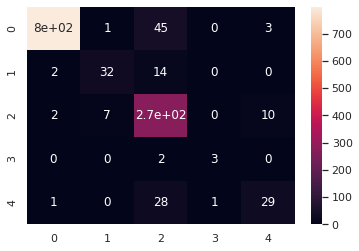

In [46]:
df_cm = pd.DataFrame(confusion_matrix(y_test_dfs_filled, y_test_hat_dfs_filled))
plt.figure()
sns.heatmap(df_cm, annot=True)

In [47]:
X.shape, result.shape

((5551, 76), (5551, 80))

In [48]:
# non ci sono -1 perché li ho tutti esclusi con il controllo Outcome != -1
X['Charlson_Diabete'].value_counts()

0.0    2881
1.0     446
2.0      87
Name: Charlson_Diabete, dtype: int64

In [ ]:
# correggere gli HDN_CODE
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(X)